See original notebook : https://drive.google.com/drive/folders/1n0uyo6ZnAsg3eB3n8wFKrL6XPL54ctuG?usp=share_link

# Installation

In [1]:
!git clone https://github.com/NVIDIA/cuda-samples.git

Cloning into 'cuda-samples'...
remote: Enumerating objects: 14786, done.
remote: Counting objects: 100% (4178/4178), done.
remote: Compressing objects: 100% (679/679), done.
remote: Total 14786 (delta 3704), reused 3767 (delta 3496), pack-reused 10608
Receiving objects: 100% (14786/14786), 132.78 MiB | 11.62 MiB/s, done.
Resolving deltas: 100% (12473/12473), done.
Updating files: 100% (3941/3941), done.


In [2]:
!/usr/local/cuda/bin/nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Wed_Sep_21_10:33:58_PDT_2022
Cuda compilation tools, release 11.8, V11.8.89
Build cuda_11.8.r11.8/compiler.31833905_0


In [3]:
!pip install --upgrade git+https://github.com/frehseg/nvcc4jupyter.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/frehseg/nvcc4jupyter.git to /tmp/pip-req-build-pf97fuef
  Running command git clone --filter=blob:none --quiet https://github.com/frehseg/nvcc4jupyter.git /tmp/pip-req-build-pf97fuef
  Resolved https://github.com/frehseg/nvcc4jupyter.git to commit a599751b98cbb8537fe9609198030b55669535da
  Preparing metadata (setup.py) ... done
  Created wheel for NVCCPlugin: filename=NVCCPlugin-0.2-py3-none-any.whl size=2192 sha256=b584212dc5b1e373f0e5b757de09318fec5523066e0916c69a74612ea8170468
  Stored in directory: /tmp/pip-ephem-wheel-cache-nmrp7djg/wheels/4c/02/de/02070cb0bea5e90c8e1412113a24c8967f93b63f8806e2b398
Successfully built NVCCPlugin


In [4]:
%load_ext nvcc_plugin

Based on the lecture at https://sites.google.com/site/frehseg/teaching/ia307

# Code

## CUDA Utilities

In [5]:
%%writefile cuda_stuff.cuh
#include <stdio.h>
#include <stdlib.h>
#include <cuda.h>
#include <cuda_runtime.h>
#include <helper_cuda.h>

#ifndef cuda_stuff_H
#define cuda_stuff_H

/* transform matrix index to vector offset
   Since CUDA uses column major, 
   nb_rows = number of rows */
#define IDX2C(i,j,nb_rows) (((j)*(nb_rows))+(i))
 
//MACRO TO DEBUGG CUDA FUNCTIONS
/** Error checking,
 *  taken from https://stackoverflow.com/questions/14038589/what-is-the-canonical-way-to-check-for-errors-using-the-cuda-runtime-api
 */
#define gpuErrchk(ans) { gpuAssert((ans), __FILE__, __LINE__); }
inline void gpuAssert(cudaError_t code, const char *file, int line, bool abort=true)
{
   if (code != cudaSuccess) 
   {
      fprintf(stderr,"GPUassert: %s %s %d\n", cudaGetErrorString(code), file, line);
      if (abort) exit(code);
   }
}
/** Error checking for use with CUDA Dynamic Parallelism */
/*
#define cdpErrchk(ans) { cdpAssert((ans), __FILE__, __LINE__); }
__device__ void cdpAssert(cudaError_t code, const char *file, int line, bool abort=true)
{
   if (code != cudaSuccess)
   {
      printf("GPU kernel assert: %s %s %d\n", cudaGetErrorString(code), file, line);
      if (abort) assert(0);
   }
}
*/
void device_synchronize();

#endif


Writing cuda_stuff.cuh


In [6]:
%%writefile cuda_stuff.cu
#include <stdio.h>
#include <stdlib.h>
#include <cuda.h>
#include <cuda_runtime.h>
#include <helper_cuda.h>
#include "cuda_stuff.cuh"

void device_synchronize(){
    gpuErrchk(cudaDeviceSynchronize());
}

Writing cuda_stuff.cu


## fmatrix Matrix Tools

In [7]:
%%writefile fmatrix.cuh
#ifndef fmatrices_H
#define fmatrices_H
#include "cuda_stuff.cuh" // for IDX2C

typedef struct {
    float* data;
    int cols;
    int rows;
} fmatrix;

/* Access element (i,j) of matrix mat */
#define getfm(mat,i,j) (mat.data[IDX2C(i,j,mat.rows)])


int fmatrix_elements(fmatrix mat);
int fmatrix_size(fmatrix mat);
/** Assert that the matrix is coherent: all fields nonzero. */
void fmatrix_assert();

fmatrix fmatrix_create_on_host(int rows, int cols);
fmatrix fmatrix_create_on_device(int rows, int cols);
void fmatrix_data_to_host(fmatrix mat_host, fmatrix mat_device);
void fmatrix_data_to_device(fmatrix mat_host, fmatrix mat_device);
fmatrix fmatrix_copy_to_host(fmatrix mat_host);
fmatrix fmatrix_copy_to_device(fmatrix mat_host);
void fmatrix_free_on_host(fmatrix* mat);
void fmatrix_free_on_device(fmatrix* mat);

/** Create a matrix representing columns [a,b) of M. 
 *  Note that the new matrix points into the
 *  data of M. The data is not copied to a new location.
 */
fmatrix fmatrix_subcolumns(fmatrix M, int a, int b);

/** Print the first nb rows of the matrix mat
 *  on the host. 
 *  If nb<0, print all rows. 
 */
 __host__
 __device__
void fmatrix_print(fmatrix mat, int nb=-1);

/** Print the first nb rows of the matrix mat
 *  on the device. 
 *  If nb<0, print all rows. 
 *
 *  This version copies the matrix to host first.
 */
void fmatrix_device_print(fmatrix mat, int nb=-1);

#endif


Writing fmatrix.cuh


In [8]:
%%writefile fmatrix.cu
#include <assert.h>
#include <stdio.h>
#include <stdlib.h>
#include <cuda.h>
#include <cuda_runtime.h>
#include <helper_cuda.h>
#include "cuda_stuff.cuh"
#include "fmatrix.cuh"

int fmatrix_elements(fmatrix mat) {
     return mat.cols*mat.rows;
}

int fmatrix_size(fmatrix mat) {
     return fmatrix_elements(mat) * sizeof(mat.data[0]);
}

void fmatrix_assert(fmatrix mat) {
    assert(mat.data);
    assert(mat.cols);
    assert(mat.rows);
}

fmatrix fmatrix_create_on_host(int rows, int cols) {
    assert(cols>0);
    assert(rows>0);
    fmatrix mat;
    mat.cols = cols;
    mat.rows = rows;
    mat.data = (float*)malloc(fmatrix_size(mat)); 
    assert(mat.data);
    return mat;
}

fmatrix fmatrix_create_on_device(int rows, int cols) {
    assert(cols>0);
    assert(rows>0);
    fmatrix mat;
    mat.cols = cols;
    mat.rows = rows;
    gpuErrchk( 
        cudaMalloc((void **)&(mat.data), fmatrix_size(mat)) 
    );
    return mat;
}

void fmatrix_data_to_device(fmatrix mat_host, fmatrix mat_device) {
    fmatrix_assert(mat_host);
    fmatrix_assert(mat_device);
    assert(mat_host.cols==mat_device.cols);
    assert(mat_host.rows==mat_device.rows);
    gpuErrchk( 
        cudaMemcpy( mat_device.data, mat_host.data, 
                   fmatrix_size(mat_host), 
                   cudaMemcpyHostToDevice 
                   )
        );
}

void fmatrix_data_to_host(fmatrix mat_host, fmatrix mat_device) {
    fmatrix_assert(mat_host);
    fmatrix_assert(mat_device);
    assert(mat_host.cols==mat_device.cols);
    assert(mat_host.rows==mat_device.rows);
    gpuErrchk(
        cudaMemcpy( mat_host.data, mat_device.data,  
                   fmatrix_size(mat_device), 
                   cudaMemcpyDeviceToHost 
                   )
        );
}

fmatrix fmatrix_copy_to_host(fmatrix mat_device) {
    fmatrix_assert(mat_device);
    fmatrix mat_host = fmatrix_create_on_host(mat_device.rows, mat_device.cols);
    fmatrix_data_to_host(mat_host,mat_device);
    return mat_host;
}

fmatrix fmatrix_copy_to_device(fmatrix mat_host) {
    fmatrix_assert(mat_host);
    fmatrix mat_device = fmatrix_create_on_device(mat_host.rows, mat_host.cols);
    fmatrix_data_to_device(mat_host,mat_device);
    return mat_device;
}

void fmatrix_free_on_host(fmatrix* mat) {
    fmatrix_assert(*mat);  
  free(mat->data);
  mat->data = 0;
  mat->cols = 0;
  mat->rows = 0;
}

void fmatrix_free_on_device(fmatrix* mat) {
    fmatrix_assert(*mat);  
  gpuErrchk(cudaFree(mat->data));
  mat->data = 0;
  mat->cols = 0;
  mat->rows = 0;
}

fmatrix fmatrix_subcolumns(fmatrix M, int a, int b) {
    fmatrix_assert(M);  
    fmatrix A = { 
        .data = &getfm(M,0,a),  
        .cols = b-a,
        .rows = M.rows 
    };
    fmatrix_assert(A);  
    return A;
}


__host__
__device__
void fmatrix_print(fmatrix mat, int nb){
    if (nb<0 || nb > mat.rows) {
        nb = mat.rows;
    }
    printf("[\n");
    for (int i = 0 ; i < nb; i++){
      for (int j = 0 ; j<mat.cols; j++){
        printf("%f", getfm(mat,i,j));
        if (j+1<mat.cols) {
          printf(",\t");
        }
      }
      if (i+1<nb) {
        printf(";\n");
      }
    }
    if (nb < mat.rows) {
      printf("\n...\n");
    }
  printf("\n]\n");
}

void fmatrix_device_print(fmatrix mat, int nb){
   // allocate copy
   fmatrix tmp = fmatrix_copy_to_host(mat);
   fmatrix_print(tmp,nb);
   fmatrix_free_on_host(&tmp);
}



Writing fmatrix.cu


## Data I/O

In [9]:
%%writefile read_csv.cuh
#include <cuda_runtime.h>
#ifndef read_csv_H
#define read_csv_H

void read_csv(const char* filename, float* data_array,int nbrow,int nbcol);

#endif

Writing read_csv.cuh


In [10]:
%%writefile read_csv.cu


#include <stdio.h>
#include <stdlib.h>
#include <string.h>

#include <iostream>
#include <iomanip>
#include <math.h>
#include <fstream>

#include "read_csv.cuh"
#include "cuda_stuff.cuh" // for matrix indexing

using namespace std;

/////////////////////////////////////////////////////////
// Functions for reading the dataset from a file
/////////////////////////////////////////////////////////

/* Read a csv file with a given number of rows and columns */
void read_csv(const char* filename, float* data_array,int nbrow,int nbcol) {
  string row_as_string;
  string value;
  double ioTemp;
  ifstream infile;
  infile.open(filename, ifstream::in);
  int row_count = 0;
	if (infile.is_open())
  {
      // read the headers (and discard)
			getline(infile, row_as_string, '\n');
      cout << "headers: " << row_as_string << "!" << std::endl;
      for(int i = 0; i < nbrow; i++){
  			getline(infile, row_as_string, '\n');
        // cout << "read line " << row_as_string << "!" << std::endl;
				istringstream line_stream(row_as_string);
			  for(int j = 0; j < nbcol; j++){
          getline(line_stream, value, ',');
					ioTemp = strtod(value.c_str(), NULL); 
          // cout << "("<<i<<","<<j<<") = "<< ioTemp << std::endl;

					data_array[IDX2C(i,j,nbrow)] = ioTemp;

				}
        ++row_count;
			}
		infile.close();
    cout << "Read " << row_count << " rows." << std::endl;
	}
	else cout << "Cannot open file." << endl;
}



Writing read_csv.cu


In [11]:
%%writefile preprocess_data.cuh

#include <cuda_runtime.h>
#ifndef preprocess_data_H
#define preprocess_data_H

void get_inputs_and_labels(float* data_array, float** input_array, float** label_array, int nbrows, int nbcols, int nb_inputs, int nb_labels );

#endif

Writing preprocess_data.cuh


In [12]:
%%writefile preprocess_data.cu
#include <stdio.h>
#include <stdlib.h>
#include <string.h>

#include <iostream>
#include <iomanip>
#include <math.h>
#include <fstream>

/*Matrix multiplication functions and other auxiliary functions*/
#include "preprocess_data.cuh"

using namespace std;

/* transform matrix index to vector offset
   Since CUDA uses column major, 
   ld = number of rows 
   Example of use: a[IDX2C(0, 1, 50)] */
#define IDX2C(i,j,ld) (((j)*(ld))+(i))

//Number of thread per block
#define THREADS_PER_BLOCK 1024
/* Constants for housing data set */
#define data_columns  (9)
#define above_threshold (265000.0)

/////////////////////////////////////////////////////////
// Number of rows in arrays to print for debugging
/////////////////////////////////////////////////////////
#define print_rows (10)
/////////////////////////////////////////////////////////
// Functions for preprocessing the data set
/////////////////////////////////////////////////////////

/* Split data into inputs and labels. Allocated memory for inputs and labels.
   Since cuBLAS is column major, each input is in a column.
   We also add 1.0 as first element to each input vector.
*/
void get_inputs_and_labels(float* data_array, float** input_array, float** label_array, int nbrows, int nbcols, int nb_inputs, int nb_labels ) {
    // The inputs are the first nbrows-1 columns.
    // The labels are the last column (index nbrows-1), booleanized
    // by the condition >= above_threshold
    *input_array = (float *)malloc(nbrows * nb_inputs * sizeof(float));    
    *label_array = (float *)malloc(nbrows * nb_labels * sizeof(float));    
    //cout << &input_array << " and "<< &label_array << " data " << data_array << std::endl;
    cout << "Allocated memory for inputs: " << nbrows << " rows, "<< nb_inputs << " columns." << std::endl;
    cout << "Allocated memory for labels: " << nbrows << " rows, "<< nb_labels << " columns." << std::endl;

    // Copy the data to X
    for(int i = 0; i < nbrows; i++){
      // Set the first element of each x to 1  
      (*input_array)[IDX2C(0,i,nb_inputs)] = 1.0;
      // Copy the rest of x
			for(int j = 1; j < nb_inputs; j++){
				(*input_array)[IDX2C(j,i,nb_inputs)] = data_array[IDX2C(i,j-1,nbrows)];
			}
      float median_house_value = data_array[IDX2C(i,nbcols-1,nbrows)];
      (*label_array)[IDX2C(0,i,nb_labels)] = 0.0;
      (*label_array)[IDX2C(1,i,nb_labels)] = 0.0;
      if (median_house_value >= above_threshold) {
        (*label_array)[IDX2C(0,i,nb_labels)] = 1.0;
      } else {
        (*label_array)[IDX2C(1,i,nb_labels)] = 1.0;        
      }
		}    
    
    // Show some entries for double checking
    cout << "Inputs (first "<<print_rows<<"):" << std::endl;
	  for(int j = 0; j < nb_inputs; j++){
      for(int i = 0; i < nbrows && i < print_rows; i++){
				cout << (*input_array)[IDX2C(j,i,nb_inputs)] << "\t";
			}
      cout << "\n";
		}
    cout << "Labels (first "<<print_rows<<"):" << std::endl;
    for(int j = 0; j < nb_labels; j++){
      for(int i = 0; i < nbrows && i < print_rows; i++){
				cout << (*label_array)[IDX2C(j,i,nb_labels)] << "\t";
			}
      cout << "\n";
		}
}

Writing preprocess_data.cu


## Classifier Math

In [13]:
%%writefile classifier_math.cuh
#ifndef classifier_math_H
#define classifier_math_H

#include "fmatrix.cuh"

/** Returns a random float between min and max (including). */
float float_rand( float min, float max );

/** Initialize W with Xavier's method,
 *  scaled by a. */
void xavier_weight_init(float a, fmatrix W);

/** Compute the softmax for each column of Z and store in P **/
void softmax_col(fmatrix P,fmatrix Z); 

///////////////////////////////////
// Matrix math
///////////////////////////////////
void fmatrix_transp_mul(fmatrix Z,float a,fmatrix X,fmatrix Y);

///////////////////////////////////
//Compute the gradient
///////////////////////////////////

void compute_gradient(int batch_size, fmatrix P, fmatrix Y,fmatrix Q, fmatrix X, fmatrix G);

///////////////////////////////////
//Compute the gradient update
///////////////////////////////////

void update_weights(fmatrix W, float learning_rate, fmatrix G);

//NORMALIZE
/////////////////////////////////

void normalize(fmatrix d_X);


//CLIPPING THE gradient
///////////////////////////////////////
void clip(fmatrix d_G, float g_max);

#endif

Writing classifier_math.cuh


In [14]:
%%writefile classifier_math.cu
#include "classifier_math.cuh"
#include "cuda_stuff.cuh"
#include <cuda.h>
#include <cuda_runtime.h>
#include <helper_cuda.h>
#include <math.h>
#include <assert.h>
#define THREADS_PER_BLOCK 1024

/////////////////////////////////////////////////////////
// Auxiliary function
/////////////////////////////////////////////////////////
// generate random numbers in interval [min,max]
float float_rand( float min, float max )
{
    float scale = rand() / (float) RAND_MAX; /* [0, 1.0] */
    return min + scale * ( max - min );      /* [min, max] */
}

void xavier_weight_init(float a, fmatrix W){
    srand(time(NULL));
    for (int j = 0; j < W.rows  ; ++j) {
      for (int i = 0; i < W.cols  ; ++i) {
          getfm(W,j,i) = a * (1.0/sqrt(W.cols+W.rows)) * float_rand(-1.0,1.0);
      }
    }
}
//Compute the softmax activation
//////////////////////////////////////////////////////

__global__ void softmax_col_kernel( fmatrix P,fmatrix Z) {
    int index = blockIdx.x*blockDim.x+threadIdx.x;
    if (index < Z.cols ){
        float sum_t = 0.0;
        float softmax = -getfm(Z,0,index);
        for (int row = 0; row<Z.rows; row++){
                if (getfm(Z,row,index) > -softmax){
                    softmax = -getfm(Z,row,index);
                }
            }
        for (int k = 0; k<Z.rows; k++){
            sum_t += exp(getfm(Z,k,index) + softmax);
        }
        for (int k = 0; k<Z.rows; k++){
            getfm(P,k, index) = (exp(getfm(Z,k,index) + softmax)/sum_t);
        }
    }
    __syncthreads(); 
}


void softmax_col(fmatrix P,fmatrix Z) {
    assert(P.cols==Z.cols);
    assert(P.rows==Z.rows);
    
    ///////////////////////////////////
    // Softmax
    ///////////////////////////////////
    int threadsPerBlock = Z.cols;
    int blocksPerGrid = 1;
    if (threadsPerBlock > THREADS_PER_BLOCK){
        blocksPerGrid = ceil(double(threadsPerBlock)/double(THREADS_PER_BLOCK));
        threadsPerBlock = THREADS_PER_BLOCK;
    }
    softmax_col_kernel<<< blocksPerGrid, threadsPerBlock >>>(P,Z);
    device_synchronize();
    
    gpuErrchk( cudaPeekAtLastError() );
    device_synchronize();
}

///Matrix mult with transposition such as compute Z = W^T X
/////////////////////////////////////////////////////////////////

__global__ 
void fmatrix_transp_mul_kernel(fmatrix Z,float a,fmatrix X,fmatrix Y) {
    int idx = blockIdx.x*blockDim.x+threadIdx.x;
    int j = idx / Z.rows;
    int i = idx % Z.rows;
    // printf("(%d,%d) \n",i,j);
    if (i < Z.rows && j < Z.cols ){
        getfm(Z,i,j) = 0.0;
        for (int k = 0; k< X.rows ; ++k) {
          // printf("%f + %f * %f * %f\n", getfm(Z,i,j), a,getfm(X,k,i),getfm(Y,k,j));
          getfm(Z,i,j) += a*getfm(X,k,j)*getfm(Y,k,i);
        }
    }
    __syncthreads(); 
}

void fmatrix_transp_mul(fmatrix Z,float a,fmatrix X,fmatrix Y) {
    assert(Z.rows == Y.cols);
    assert(Z.cols == X.cols);
    assert(X.rows == Y.rows);

    //printf("Z(%d,%d) elements %d \n",Z.rows,Z.cols,fmatrix_elements(Z));
    //printf("X(%d,%d) elements %d \n",X.rows,X.cols,fmatrix_elements(X));
    int threadsPerBlock = fmatrix_elements(Z);
    int blocksPerGrid = 1;
    if (threadsPerBlock > THREADS_PER_BLOCK){
        blocksPerGrid = (threadsPerBlock-1)/THREADS_PER_BLOCK+1;
        threadsPerBlock = THREADS_PER_BLOCK;
    }
    fmatrix_transp_mul_kernel<<< blocksPerGrid, threadsPerBlock >>>(Z,a,X,Y);
    gpuErrchk( cudaPeekAtLastError() );
}

///Matrix mult with transposition such as compute  G = 1/batch_size * X * Q^T
/////////////////////////////////////////////////////////////////


__global__ 
void fmatrix_transp_mul_kernel_2(fmatrix G,float a,fmatrix X,fmatrix Q) {
    int idx = blockIdx.x*blockDim.x+threadIdx.x;
    int j = idx / G.rows;
    int i = idx % G.rows;
    // printf("(%d,%d) \n",i,j);
    if (i < G.rows && j < G.cols ){
        getfm(G,i,j) = 0.0;
        for (int k = 0; k< X.cols ; ++k) {
          // printf("%f + %f * %f * %f\n", getfm(Z,i,j), a,getfm(X,k,i),getfm(Y,k,j));
          getfm(G,i,j) += a*getfm(X,i,k)*getfm(Q,j,k);
        }
    }
    __syncthreads(); 
}

//COMPUTE THE GRADIENT
//////////////////////////////////////////////
__global__
void compute_Q_kernel(fmatrix P, fmatrix Y,fmatrix Q){
    int idx = blockIdx.x*blockDim.x+threadIdx.x;
    int j = idx / Q.rows;
    int i = idx % Q.rows;
    if (i < Q.rows && j < Q.cols ){
      getfm(Q, i, j) = getfm(P, i, j) - getfm(Y, i, j);
    }
    __syncthreads(); 
}


void compute_gradient(int batch_size, fmatrix P,  fmatrix Y, fmatrix Q, fmatrix X , fmatrix G){
    assert(P.rows == Y.rows);
    assert(P.cols == Y.cols);
    assert(Q.rows == Y.rows);
    assert(Q.cols == Y.cols);
    assert(batch_size != 0);
    assert(G.rows == X.rows);
    assert(G.cols == Q.rows);
    assert(Q.cols == X.cols);
    int threadsPerBlock = fmatrix_elements(P);
    int blocksPerGrid = 1;
    if (threadsPerBlock > THREADS_PER_BLOCK){
        blocksPerGrid = (threadsPerBlock-1)/THREADS_PER_BLOCK+1;
        threadsPerBlock = THREADS_PER_BLOCK;
    }
    //compute Q on kernel : Q = P-Y
    compute_Q_kernel<<< blocksPerGrid, threadsPerBlock >>>(P,Y,Q);
    gpuErrchk( cudaPeekAtLastError() );
    device_synchronize();
    /*printf("P(%d,%d) elements %d \n",P.rows,P.cols,fmatrix_elements(P));
    printf("Y(%d,%d) elements %d \n",Y.rows,Y.cols,fmatrix_elements(Y));
    printf("Q(%d,%d) elements %d \n",Q.rows,Q.cols,fmatrix_elements(Q));
    printf("G(%d,%d) elements %d \n",G.rows,G.cols,fmatrix_elements(G));*/

    //update W on kernel : G = 1/batch_size * X * Q^T
    float a = (float) 1/batch_size;
    threadsPerBlock = fmatrix_elements(G);
    blocksPerGrid = 1;
    if (threadsPerBlock > THREADS_PER_BLOCK){
        blocksPerGrid = (threadsPerBlock-1)/THREADS_PER_BLOCK+1;
        threadsPerBlock = THREADS_PER_BLOCK;
    }
    
    fmatrix_transp_mul_kernel_2<<< blocksPerGrid, threadsPerBlock >>>( G,a ,X, Q );
    gpuErrchk( cudaPeekAtLastError() );
    device_synchronize();
    
}


//COMPUTE THE GRADIENT : W = W - learning_rate*G
///////////////////////////////////////////////////////

__global__
void update_weights_kernel(fmatrix W, float learning_rate, fmatrix G){
    int idx = blockIdx.x*blockDim.x+threadIdx.x;
    int j = idx / W.rows;
    int i = idx % W.rows;
    // printf("(%d,%d) \n",i,j);
    if (i < W.rows && j < W.cols ){
        getfm(W,i,j) -= learning_rate*getfm(G,i,j);
    }
    __syncthreads(); 
}

void update_weights(fmatrix W, float learning_rate, fmatrix G){
    assert(W.rows == G.rows);
    assert(W.cols == G.cols);
    assert(learning_rate != 0.0);

    int threadsPerBlock = fmatrix_elements(W);
    int blocksPerGrid = 1;
    if (threadsPerBlock > THREADS_PER_BLOCK){
        blocksPerGrid = (threadsPerBlock-1)/THREADS_PER_BLOCK+1;
        threadsPerBlock = THREADS_PER_BLOCK;
    }
    //printf("W(%d,%d) elements %d \n",W.rows,W.cols,fmatrix_elements(W));

    update_weights_kernel<<< blocksPerGrid, threadsPerBlock >>>(W, learning_rate, G);
    gpuErrchk( cudaPeekAtLastError() );
    device_synchronize();
}


///NORMALIZATION
///////////////////////////////////////////////////////
__global__
void normalize_kernel(fmatrix d_X){
    int index = blockIdx.x*blockDim.x+threadIdx.x;
    float temp = 0.0;
    float mu = 0.0;
    float var = 0.0;
    if (index < d_X.rows && index > 0){
        temp = 0;
        for (int k = 0; k< d_X.cols ; ++k) {
          temp += getfm(d_X,index,k);
        }
        mu = (float)temp/d_X.cols;
        var = 0;
        for (int k = 0; k< d_X.cols ; ++k) {
          var += pow((getfm(d_X,index,k)-mu), 2);
        }
        var = sqrt(var/d_X.cols);
        for (int k = 0; k< d_X.cols ; ++k) {
          getfm(d_X,index,k) = (getfm(d_X,index,k) - mu)/var;
        }
    }
    __syncthreads(); 
}


void normalize(fmatrix d_X){
    int threadsPerBlock = d_X.rows;
    int blocksPerGrid = 1;
    if (threadsPerBlock > THREADS_PER_BLOCK){
        blocksPerGrid = (threadsPerBlock-1)/THREADS_PER_BLOCK+1;
        threadsPerBlock = THREADS_PER_BLOCK;
    }
    //printf("W(%d,%d) elements %d \n",W.rows,W.cols,fmatrix_elements(W));

    normalize_kernel<<< blocksPerGrid, threadsPerBlock >>>(d_X);
    gpuErrchk( cudaPeekAtLastError() );
    device_synchronize();
}
//GRADIENT CLIPPING
///////////////////////////////////////////////////////////

__global__
void clip_kernel(fmatrix d_G, float g_max){
    int idx = blockIdx.x*blockDim.x+threadIdx.x;
    int j = idx / d_G.rows;
    int i = idx % d_G.rows;
    float g =0.0;
    if (idx == d_G.cols*d_G.rows + 1){
        
      for (int i = 0; i< d_G.rows ; ++i) {
        for (int j = 0; j< d_G.cols ; ++j) {
            g += pow(getfm(d_G, i, j), 2);
        }
      }
      g = sqrt(g_max);
    }
    __syncthreads(); 
    if ( i < d_G.rows && j < d_G.cols && g>g_max ){
          getfm(d_G, i, j) = getfm(d_G, i, j) /(g*g_max);
    }
    __syncthreads(); 
}


void clip(fmatrix d_G, float g_max){
    int threadsPerBlock = fmatrix_elements(d_G) + 1;
    int blocksPerGrid = 1;
    if (threadsPerBlock > THREADS_PER_BLOCK){
        blocksPerGrid = (threadsPerBlock-1)/THREADS_PER_BLOCK+1;
        threadsPerBlock = THREADS_PER_BLOCK;
    }
    //printf("W(%d,%d) elements %d \n",W.rows,W.cols,fmatrix_elements(W));

    clip_kernel<<< blocksPerGrid, threadsPerBlock >>>(d_G, g_max);
    gpuErrchk( cudaPeekAtLastError() );
    device_synchronize();
}





Writing classifier_math.cu


## Evaluating Accuracy


In [15]:
%%writefile evaluate_accuracy.cuh

/** Evaluate the accuracy of a linear classifier with D x M weight
 *  matrix W, using D x N input data X and M x N output labels Y.
 *  Z is a temporary matrix with dimensions M x N,
 *  which must be previously allocated.
 */
float evaluate_accuracy(fmatrix d_W,fmatrix d_X,fmatrix d_Y,fmatrix d_Z);

/** Compute the logloss given M x N matrices of 
 *  probabilities P and output labels Y
 *  and stores it in J.
 *  J is a matrix with dimensions 1 x 1,
 *  which must be previously allocated.
 *  logloss = sum_j -Y(k,j)*log(P(k,j))
 */
float evaluate_logloss(fmatrix d_J,fmatrix d_Y, fmatrix d_Z);

Writing evaluate_accuracy.cuh


In [16]:
%%writefile evaluate_accuracy.cu
#include "fmatrix.cuh"
#include "classifier_math.cuh"
#include <assert.h>

#define THREADS_PER_BLOCK 1024

__global__ 
void evaluate_accuracy_kernel(fmatrix d_Y,fmatrix d_Z,int* count) {
    int idx = blockIdx.x*blockDim.x+threadIdx.x;
    if (idx < d_Z.cols){
        float z_max = getfm(d_Z,0,idx);
        int i_max = 0;
        for (int i = 1; i < d_Z.rows; ++i) {
          if (getfm(d_Z,i,idx)>z_max) {
                z_max = getfm(d_Z,i,idx);
                i_max = i;
          }
        }
      if (getfm(d_Y,i_max,idx)>=0.5f) {
          atomicAdd(count,1);
      }
    }    
}

float evaluate_accuracy(fmatrix d_W,fmatrix d_X,fmatrix d_Y,fmatrix d_Z) {
    assert(d_Y.cols == d_Z.cols);
    assert(d_Y.rows == d_Z.rows);

  // Z = W^T X
  /* Multiplication on the device*/

  ///////////////////////////////////
  // Z = W^T X
  ///////////////////////////////////
  fmatrix_transp_mul( d_Z, 1.0, d_X, d_W);
  device_synchronize();

  // For each column z of Z, 
  // find argmax_k z_k
  ////////////////////////////////
  int true_class = 0;

  int* d_count = 0;
  gpuErrchk(cudaMalloc((void **)&d_count, sizeof(int)));
  gpuErrchk( 
        cudaMemcpy( d_count, &true_class, sizeof(int), cudaMemcpyHostToDevice )
  );

    int threadsPerBlock = d_Z.cols;
    int blocksPerGrid = 1;
    if (threadsPerBlock > THREADS_PER_BLOCK){
        blocksPerGrid = (threadsPerBlock-1)/THREADS_PER_BLOCK+1;
        threadsPerBlock = THREADS_PER_BLOCK;
    }
    evaluate_accuracy_kernel<<< blocksPerGrid, threadsPerBlock >>>(d_Y,d_Z,d_count);
    device_synchronize();
    gpuErrchk( cudaPeekAtLastError() );

  gpuErrchk(
          cudaMemcpy(&true_class, d_count, sizeof(int), cudaMemcpyDeviceToHost )
  );

  //printf("Correct results: %d out of %d\n",true_class,nb_tested);
  //printf("Accuracy: %f\n",(float)true_class/(float)nb_tested);
  return (float)true_class/(float)d_Z.cols;
}


__global__ void evaluate_logloss_kernel( fmatrix J,fmatrix Y,fmatrix Z) {
    int index = blockIdx.x*blockDim.x+threadIdx.x;
    if (index < Z.cols ){
        float sum_t = 0.0;
        float softmax = -getfm(Z,0,index);
        for (int row = 0; row<Z.rows; row++){
                if (getfm(Z,row,index) > -softmax){
                    softmax = -getfm(Z,row,index);
                }
            }
        for (int k = 0; k<Z.rows; k++){
            sum_t += exp(getfm(Z,k,index) + softmax);
        }
        getfm(J, 0, index) = 0.0;
        for (int k = 0; k<Z.rows; k++){
            getfm(J, 0, index) -= getfm(Y,k,index)*(getfm(Z,k,index) + softmax - log(sum_t));
        }
    }
    __syncthreads(); 
}



float evaluate_logloss(fmatrix d_J,fmatrix d_Y,fmatrix d_Z) {
    assert(d_Y.cols == d_Z.cols);
    assert(d_Y.rows == d_Z.rows);
    assert(d_Y.cols == d_Z.cols);
    ///////////////////////////////////
    // Logloss
    ///////////////////////////////////
    fmatrix J_mat = fmatrix_create_on_host(1,d_Z.cols);
    float J = 0.0;
    int threadsPerBlock = d_Z.cols;
    int blocksPerGrid = 1;
    if (threadsPerBlock > THREADS_PER_BLOCK){
        blocksPerGrid = ceil(double(threadsPerBlock)/double(THREADS_PER_BLOCK));
        threadsPerBlock = THREADS_PER_BLOCK;
    }
    evaluate_logloss_kernel<<< blocksPerGrid, threadsPerBlock >>>(d_J, d_Y, d_Z);
    gpuErrchk( cudaPeekAtLastError() );
    device_synchronize();

    //fmatrix_device_print(d_J);
    //device_synchronize();

    fmatrix_data_to_host(J_mat, d_J);
     device_synchronize();
    for (int k = 0; k<J_mat.cols; k++){
        J += J_mat.data[k];
    }
    return J;
}



Writing evaluate_accuracy.cu


## Linear Classifier

In [17]:
%%writefile linear_classification.cu

#include <stdio.h>
#include <stdlib.h>
#include <string.h>

#include <iostream>
#include <iomanip>
#include <math.h>
#include <time.h>
#include <fstream>

/*Matrix multiplication functions and other auxiliary functions*/
#include "fmatrix.cuh"
#include "read_csv.cuh"
#include "preprocess_data.cuh"
#include "classifier_math.cuh"
#include "evaluate_accuracy.cuh"
/* Includes, cuda */
#include <cuda_runtime.h>
#include <helper_cuda.h>

using namespace std;

//Number of thread per block
#define THREADS_PER_BLOCK 1024
/* Constants for housing data set */
#define data_columns  (9)
#define above_threshold (265000.0)

/////////////////////////////////////////////////////////
// Number of rows in arrays to print for debugging
/////////////////////////////////////////////////////////
#define print_rows (10)


/////////////////////////////////////////////////////////
// Main program
/////////////////////////////////////////////////////////
int main(int argc, char **argv)
{
    
    /////////////////////////////////////////////////////////
    // Parameters for the data set
    /////////////////////////////////////////////////////////
    size_t N_train = 12000; //12000; // points for training (Google: 12000)
    size_t N_test = 5000; // 5000; // points for validation (Google: 5000)
    size_t N = N_train;
    size_t Nall = N_train+N_test;
    /////////////////////////////////////////////////////////
    // Reading the data set
    /////////////////////////////////////////////////////////
    fmatrix alldata = fmatrix_create_on_host(Nall,data_columns);
    read_csv("sample_data/california_housing_train.csv",alldata.data,Nall,data_columns);
    //fmatrix_print(alldata);

    size_t D = data_columns-1+1; // remove output column, add column with const. 1.0
    size_t M = 2; // number of labels (one-hot encoding)
    fmatrix Xall = fmatrix_create_on_host(D,Nall);
    fmatrix Yall = fmatrix_create_on_host(M,Nall);
    get_inputs_and_labels(alldata.data,&Xall.data,&Yall.data,Nall,data_columns,D,M);
    /////////////////////////////////////////////////////////
    // Inputs and labels are now available in X and Y.
    // Each input is a column in X; X is of dimension D x N
    // each label is a column in Y; Y is of dimension M x N
    /////////////////////////////////////////////////////////
     
    // Logfile
    FILE* fp = fopen("log.txt", "w");
    
    /////////////////////////////////////////////////////////
    // Parameters for Stochastic Gradient Descent
    /////////////////////////////////////////////////////////
    int nb_iter = 1000; //10;
    int periods = nb_iter/100; // reporting period
    int batch_size = N; // N;
    float learning_rate = 1e-3;
    float g_max = 1e-4;
 
    /////////////////////////////////////////////////////////
    // Memory Allocation and Initialization
    /////////////////////////////////////////////////////////
    // take X,Y to be the first N columns of all data
    fmatrix h_X = fmatrix_subcolumns(Xall,0,N);
    fmatrix h_Y = fmatrix_subcolumns(Yall,0,N);
    fmatrix h_Xtest = fmatrix_subcolumns(Xall,N,Nall);
    fmatrix h_Ytest = fmatrix_subcolumns(Yall,N,Nall);
    fmatrix h_W = fmatrix_create_on_host(D,M);
    fmatrix h_J = fmatrix_create_on_host(1,N_train);

    /////////////////////////////////////////////////////////
    // Initializing Weight Matrix 
    // its dimension is D x M
    /////////////////////////////////////////////////////////
    xavier_weight_init(1.0,h_W);
 
    //////////////////////////////
    // Copy data to device      //
    //////////////////////////////
    fmatrix d_X = fmatrix_copy_to_device(h_X);
    fmatrix d_Y = fmatrix_copy_to_device(h_Y);
    fmatrix d_Xtest = fmatrix_copy_to_device(h_Xtest);
    fmatrix d_Ytest = fmatrix_copy_to_device(h_Ytest);
    fmatrix d_W = fmatrix_copy_to_device(h_W);
    fmatrix d_J = fmatrix_copy_to_device(h_J);
 
    /////////////////////////////////////////
    // Create auxiliary matrices on device //
    /////////////////////////////////////////
    fmatrix d_Z = fmatrix_create_on_device(M,batch_size);
    fmatrix d_P = fmatrix_create_on_device(M,batch_size);
    fmatrix d_Q = fmatrix_create_on_device(M,batch_size);
    fmatrix d_G = fmatrix_create_on_device(D,M);
    // auxiliary matrix for computing Z=W^T X on test data
    fmatrix d_Ztest = fmatrix_create_on_device(M,d_Xtest.cols);

    /////////////////////////////////////////////////////////
    // Batch Gradient Descent
    /////////////////////////////////////////////////////////
    fmatrix_device_print(d_X);
    fmatrix_device_print(d_W);
    ////////////////////////////////////////////////////////
    //Normalization
    ///////////////////////////////////////////////////////
    normalize(d_X);
    fmatrix_device_print(d_X);
    normalize(d_Xtest);
 
 
     /* Evaluate the accuracy */
    float accuracy = 0;
    accuracy = evaluate_accuracy(d_W,d_Xtest,d_Ytest,d_Ztest);
    printf("initial accuracy: %f\n",accuracy);

    float J = 0;
 
    clock_t tstart_total, tend;
    tstart_total = clock();
 
    //int batch_pointer = 0;
    for (int i = 0; i < nb_iter; ++i ) {

      ////////////////////////////////
      // Z = W^T X
      // --> each column z of Z corresponds to one column x of X
      ////////////////////////////////
      fmatrix_transp_mul( d_Z, 1.0, d_X, d_W);
      device_synchronize();

      /*printf("matrix W");
      fmatrix_device_print(d_W);
      printf("matrix Z");
      fmatrix_device_print(d_Z);*/

      ////////////////////////////////
      // For each column z of Z, compute activation p(z);
      // then update W
      ////////////////////////////////
      // Softmax per column of Z and store in Z

      softmax_col(d_P,d_Z);
      device_synchronize();
      /*printf("matrix P");
      fmatrix_device_print(d_P);*/

      // evaluate logloss (for reporting only)
      
      // Q:=P-Y
      // gradient G = 1/batch_size XQ^T
      // update weights W = W - learning_rate*G

      compute_gradient(batch_size, d_P, d_Y, d_Q, d_X, d_G );//batch_size
      device_synchronize();

      //clip if g>g_max
      clip(d_G, g_max);
      device_synchronize();
      /*printf("matrix Y");
      fmatrix_device_print(d_Y);
      printf("matrix Q");
      fmatrix_device_print(d_Q);
      printf("matrix G");
      fmatrix_device_print(d_G);*/

      update_weights(d_W, learning_rate, d_G); //learning_rate
      device_synchronize();

      //printf("W:\n");fmatrix_device_print(d_W);
      
      ////////////////////////////////
      // For reporting, compute logloss and accuracy
      ////////////////////////////////
      if (i%(nb_iter/periods)==0) {
        J = evaluate_logloss(d_J,d_Y, d_Z);
        float accuracy = evaluate_accuracy(d_W,d_Xtest,d_Ytest,d_Ztest);
        printf("iter: %d, logloss: %f, accuracy: %f\n",i,J, accuracy);
        fprintf(fp, "%f,%f\n", J, accuracy);
      }

    }
    tend = clock();
    float duration = ((float)(tend-tstart_total))/CLOCKS_PER_SEC;
    printf("Duration (s): %f\n",duration);
    /* Evaluate the accuracy */
    accuracy = evaluate_accuracy(d_W,d_Xtest,d_Ytest,d_Ztest);
    printf("final accuracy: %f\n",accuracy);

    printf("final weights: \n");
    fmatrix_device_print(d_W);

    /* Memory clean up */
    /** No need to free h_X, h_Y, h_Xtest, h_Ytest since 
     *  they all point to Xall 
     */
    fmatrix_free_on_host(&h_W);
    fmatrix_free_on_host(&h_J);
    fmatrix_free_on_host(&Xall);
    fmatrix_free_on_host(&Yall);

    fmatrix_free_on_device(&d_X);
    fmatrix_free_on_device(&d_Y);
    fmatrix_free_on_device(&d_Xtest);
    fmatrix_free_on_device(&d_Ytest);
    fmatrix_free_on_device(&d_W);
    fmatrix_free_on_device(&d_Z);
    fmatrix_free_on_device(&d_J);
 
    // Close log file
    fclose(fp);
}

Writing linear_classification.cu


# Compiling

In [18]:
!nvcc -I cuda-samples/Common/ -L/usr/local/cuda/include -lcublas -lcusolver linear_classification.cu read_csv.cu preprocess_data.cu evaluate_accuracy.cu fmatrix.cu classifier_math.cu cuda_stuff.cu

# Experiments

In [19]:
%%time
!./a.out 

headers: "longitude","latitude","housing_median_age","total_rooms","total_bedrooms","population","households","median_income","median_house_value"!
Read 17000 rows.
Allocated memory for inputs: 17000 rows, 9 columns.
Allocated memory for labels: 17000 rows, 2 columns.
Inputs (first 10):
1	1	1	1	1	1	1	1	1	1	
-114.31	-114.47	-114.56	-114.57	-114.57	-114.58	-114.58	-114.59	-114.59	-114.6	
34.19	34.4	33.69	33.64	33.57	33.63	33.61	34.83	33.61	34.83	
15	19	17	14	20	29	25	41	34	46	
5612	7650	720	1501	1454	1387	2907	812	4789	1497	
1283	1901	174	337	326	236	680	168	1175	309	
1015	1129	333	515	624	671	1841	375	3134	787	
472	463	117	226	262	239	633	158	1056	271	
1.4936	1.82	1.6509	3.1917	1.925	3.3438	2.6768	1.7083	2.1782	2.1908	
Labels (first 10):
0	0	0	0	0	0	0	0	0	0	
1	1	1	1	1	1	1	1	1	1	
[
1.000000,	1.000000,	1.000000,	1.000000,	1.000000,	1.000000,	1.000000,	1.000000,	1.000000,	1.000000,	1.000000,	1.000000,	1.000000,	1.000000,	1.000000,	1.000000,	1.000000,	1.000000,	1.000000,	1.000000,	1.000000,

Let's plot the logloss and accuracy.

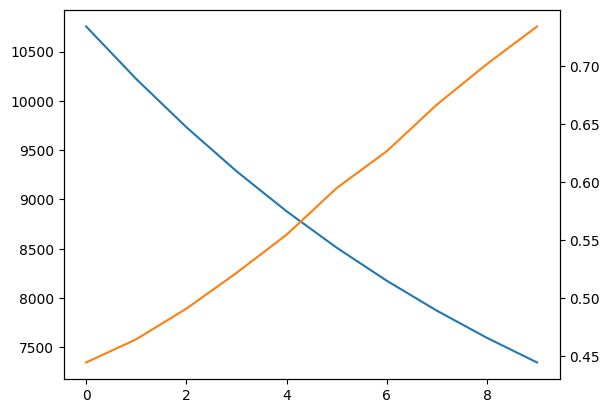

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
data = pd.read_csv('log.txt',sep=',',header=None)
fig,ax = plt.subplots()
ax.plot(data[0],label="logloss")
ax2=ax.twinx()
ax2.plot([], [])
ax2.plot(data[1],label="accuracy")
plt.show()

##Remarks

We can observe very good improvements after the normalization and the gradient clipping. However, we have to set the good parameters to observe the accuracy increase. Here, the parameters setted seems to be a choice.